# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.



As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 822.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 49.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.8.0+cu111 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you hav

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
counter = 1
spam_counter = 1
for line in open('SMSSpamCollection'):
  if line.split()[0] == "ham" and counter == 1:
    print("Non-spam SMS example:", line)
    print("Label value for non-spam SMS:", line.split()[0])
    counter -= 1
  elif line.split()[0] == "spam" and spam_counter == 1:
    print("Spam SMS example:", line)
    print("Label value for spam SMS:", line.split()[0])
    spam_counter -= 1

Non-spam SMS example: ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Label value for non-spam SMS: ham
Spam SMS example: spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Label value for spam SMS: spam


### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
non_spam_messages = 0
spam_messages = 0
for line in open('SMSSpamCollection'):
  if line.split()[0] == "ham":
    non_spam_messages += 1
  elif line.split()[0] == "spam":
    spam_messages += 1

print("Number of non-spam messages:", non_spam_messages)
print("Number of spam_messages:", spam_messages)

Number of non-spam messages: 4827
Number of spam_messages: 747


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [ ]:
# One advantage of modelling SMS text messages as a sequence of characters is that characters are capable of capturing
# important information such as capitalization and spellign mistakes that could be missed if words were used instead.
# This allows for more flexibility which can improve accuracy when performing tasks such as sentiment analysis.
# Another advantage would be that it would eliminate the problem of out of vocabulary words. Since we are focusing on letters
# rather than words, it completely eliminates the issue of explicitly modelling individual words. This simiplifies the process
# of capturing and learning from rare words.

# One disadvantage of modelling using characters is the increased complexity that comes as a result. Since there will always be
# more characters than words, the input data will be of much larger size and the model will have to learn patterns at the
# character level. This would increase the training time and the complexity of the model. Another disadvantage would be the fact
# that characters themselves have little to no semantic meaning. So if we simply focus on the characters, it would be quite
# difficult to capture the meaning of phrases and words.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

train, valid, test = dataset.split([0.6, 0.2, 0.2], True)
print("training items:", len(train))
print("validation items:", len(valid))
print("testing items:", len(test))

training items: 3343
validation items: 1115
testing items: 1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

In [ ]:
# Having a balanced dataset will prove to be extremely helpful to training the neural network since it helps to
# prevent biases and inaccuracies in its final predictions. If the training dataset is left unbalanced, where there
# are several more examples of one type than another, the end result will be a network that is much more likely
# to predict that something is a "ham" message rather than a "spam" message. Even if we made it so that the
# model predicted "ham" on every single message in the trainign set, the model would achieve a deceivingly high
# accuracy rating.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
print("STOI")
print(text_field.vocab.stoi)
print("\n")
print("ITOS")
print(text_field.vocab.itos)

STOI
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f26762101f0>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, 'd': 14, '.': 15, '0': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, 'b': 25, '2': 26, 'T': 27, '8': 28, 'k': 29, 'E': 30, 'v': 31, 'S': 32, '5': 33, 'I': 34, 'O': 35, 'C': 36, '4': 37, '7': 38, 'N': 39, 'A': 40, 'x': 41, '6': 42, '3': 43, 'R': 44, '!': 45, ',': 46, 'P': 47, '9': 48, 'U': 49, 'M': 50, 'W': 51, 'L': 52, 'H': 53, 'D': 54, 'F': 55, 'B': 56, 'G': 57, '/': 58, "'": 59, 'Y': 60, '?': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'X': 66, 'V': 67, 'z': 68, 'j': 69, 'K': 70, ')': 71, 'J': 72, '+': 73, ';': 74, '*': 75, '(': 76, 'Q': 77, '"': 78, 'q': 79, '#': 80, '>': 81, '@': 82, '=': 83, 'Z': 84, 'ü': 85, 'Ü': 86, '<': 87, '‘': 88, '|': 89, '_': 90, '\x92': 91, '[': 92, ']': 93, '$': 94, '…': 95, '\x93': 96, 'ú': 97, '–'

In [ ]:
# The 'stoi' stands for string to index, and the variable text_field.vocab.stoi itself is a dictionary-like object that maps each token in the vocabulary of the
# text_field to a corresponding integer value which acts as a label.
# The 'itos' stands for index to string and the variable text_field.vocab.itos is a list-like object that lists out token characters according to their integer label.

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [ ]:
# <unk> represents all unknown characters tokens that do not exist in the vocabulary/dictionary used by the model.
# <pad> is another special token which is simply used as padding within sentences to help fix them all to the same length.
# The <pad> token is typically added to the end of shorter sentences to make sure all of them are at a fixed length.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
for batch in train_iter:
  print(len(batch))
  print(batch.sms)
  print(batch.label)

In [ ]:
counter = 0
for batch in train_iter:
  if counter == 10:
    break
  else:
    padding = 0
    print("Batch {}:".format(counter+1))
    max_length = batch.sms[1][0]
    print("\tMax length is {}".format(max_length))
    for sms in batch.sms[1]:
        padding += batch.sms[1][0] - sms
    print("\tNumber of <pad> tokens used:", int(padding))
  counter += 1

Batch 1:
	Max length is 70
	Number of <pad> tokens used: 50
Batch 2:
	Max length is 82
	Number of <pad> tokens used: 32
Batch 3:
	Max length is 26
	Number of <pad> tokens used: 25
Batch 4:
	Max length is 23
	Number of <pad> tokens used: 27
Batch 5:
	Max length is 158
	Number of <pad> tokens used: 0
Batch 6:
	Max length is 65
	Number of <pad> tokens used: 62
Batch 7:
	Max length is 101
	Number of <pad> tokens used: 60
Batch 8:
	Max length is 13
	Number of <pad> tokens used: 170
Batch 9:
	Max length is 146
	Number of <pad> tokens used: 0
Batch 10:
	Max length is 25
	Number of <pad> tokens used: 25


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
characters = text_field.vocab.itos
input_size = len(characters)

In [ ]:
class RNN(nn.Module):
  def __init__(self, hidden_size, input_size):
    super(RNN, self).__init__()
    self.name = "RNN"
    self.emb = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, 2)

  def forward(self, x):
    x = self.emb[x]
    h = torch.zeros(1, x.size(0), self.hidden_size)
    out, _ = self.rnn(x, h)
    out = self.fc(out[:, -1, :])
    return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data, batch_size):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct = 0
    total = 0

    data_loader = torchtext.legacy.data.BucketIterator(data, batch_size=batch_size, sort_key=lambda x: len(x.sms), sort_within_batch=True, repeat=False)

    for sms, label in data_loader:
      output = model(sms[0])
      prediction = output.max(1, keepdim=True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()
      total += label.shape[0]

    accuracy = correct / total

    return accuracy


### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [ ]:
import matplotlib.pyplot as plt

def train_network(model, train_data, valid_data, batch_size, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, train_acc, valid_losses, valid_acc = [], [], [], []
    epochs = []

    train_loader = torchtext.legacy.data.BucketIterator(train_data, batch_size=batch_size, sort_key=lambda x: len(x.sms), sort_within_batch=True, repeat=False)
    valid_loader = torchtext.legacy.data.BucketIterator(valid_data, batch_size=batch_size, sort_key=lambda x: len(x.sms), sort_within_batch=True, repeat=False)

    for epoch in range(num_epochs):
        for sms, labels in train_loader:
            optimizer.zero_grad()
            pred = model(sms[0])
            train_loss = criterion(pred, labels)
            train_loss.backward()
            optimizer.step()

        train_losses.append(float(train_loss))

        for sms, labels in valid_loader:
            pred = model(sms[0])
            val_loss = criterion(pred, labels)

        epochs.append(epoch)
        valid_losses.append(float(val_loss))

        training_acc = get_accuracy(model, train_data, batch_size)
        val_acc = get_accuracy(model, valid_data, batch_size)

        train_acc.append(training_acc)
        valid_acc.append(val_acc)
        print("Epoch {}: \tTraining Accuracy: {} Training Loss: {} \nValidation Accuracy: {} Validation Loss: {}".format(epoch+1, train_acc[-1], train_losses[-1], valid_acc[-1], valid_losses[-1]))

        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training and Validation Losses Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training and Validation Accuracy Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1: 	Training Accuracy: 0.4878129663405737 Training Loss: 0.7096992135047913 
Validation Accuracy: 0.8645739910313901 Validation Loss: 0.6867982745170593
Epoch 2: 	Training Accuracy: 0.4879787763223346 Training Loss: 0.741607129573822 
Validation Accuracy: 0.863677130044843 Validation Loss: 0.6358000040054321
Epoch 3: 	Training Accuracy: 0.4967667053556624 Training Loss: 0.6716315746307373 
Validation Accuracy: 0.8609865470852018 Validation Loss: 0.6974042654037476
Epoch 4: 	Training Accuracy: 0.5035649146078593 Training Loss: 0.7163069844245911 
Validation Accuracy: 0.8600896860986547 Validation Loss: 0.6439145803451538
Epoch 5: 	Training Accuracy: 0.5130160835682308 Training Loss: 0.6600182056427002 
Validation Accuracy: 0.8573991031390135 Validation Loss: 0.6439549326896667


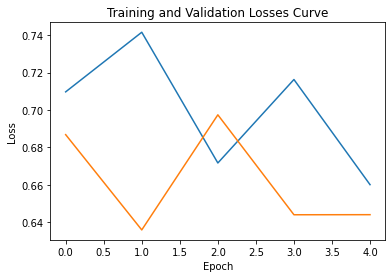

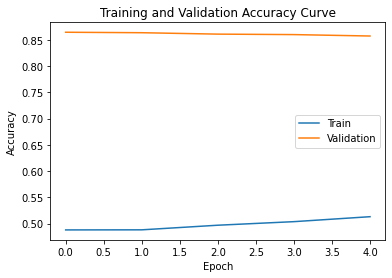

In [ ]:
# initial test using default hyperparameters
model_initial = RNN(input_size, input_size)
train_network(model_initial, train, valid, batch_size=64)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 1: 	Training Accuracy: 0.5304261316531255 Training Loss: 0.6774702668190002 
Validation Accuracy: 0.14260089686098654 Validation Loss: 0.6956191658973694
Epoch 2: 	Training Accuracy: 0.6982258331951583 Training Loss: 0.639227032661438 
Validation Accuracy: 0.8008968609865471 Validation Loss: 0.6609143614768982
Epoch 3: 	Training Accuracy: 0.8618802851931686 Training Loss: 0.5074224472045898 
Validation Accuracy: 0.8986547085201794 Validation Loss: 0.5531433820724487
Epoch 4: 	Training Accuracy: 0.9031669706516332 Training Loss: 0.15037724375724792 
Validation Accuracy: 0.8726457399103139 Validation Loss: 0.5070065855979919
Epoch 5: 	Training Accuracy: 0.915271099320179 Training Loss: 0.357693612575531 
Validation Accuracy: 0.915695067264574 Validation Loss: 0.3176175355911255
Epoch 6: 	Training Accuracy: 0.8937158016912619 Training Loss: 0.5128443837165833 
Validation Accuracy: 0.9336322869955157 Validation Loss: 0.25745734572410583
Epoch 7: 	Training Accuracy: 0.923893218371746 

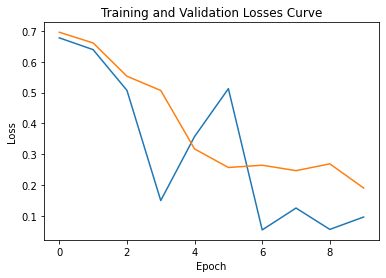

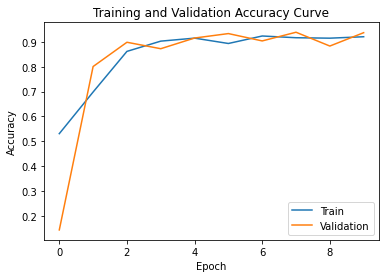

In [ ]:
# I changed the hidden size to 100 and increased the number of epoches to 10 to see how the model would perform at later iteration.
# I also increased the learning_rate = to 0.00001 to see how the model would be changed if the learning rate was increased
# to accelerate the rate at which the accuracy was increased.
model1 = RNN(100, input_size)
train_network(model1, train, valid, batch_size=64, num_epochs=10, learning_rate=0.0001)

Epoch 1: 	Training Accuracy: 0.5199801028021886 Training Loss: 0.6687690615653992 
Validation Accuracy: 0.13542600896860987 Validation Loss: 0.7052136063575745
Epoch 2: 	Training Accuracy: 0.5199801028021886 Training Loss: 0.6216972470283508 
Validation Accuracy: 0.13542600896860987 Validation Loss: 0.7666424512863159
Epoch 3: 	Training Accuracy: 0.5199801028021886 Training Loss: 0.7267410159111023 
Validation Accuracy: 0.13542600896860987 Validation Loss: 0.6888343691825867
Epoch 4: 	Training Accuracy: 0.5199801028021886 Training Loss: 0.6249945163726807 
Validation Accuracy: 0.13542600896860987 Validation Loss: 0.7545378804206848
Epoch 5: 	Training Accuracy: 0.5199801028021886 Training Loss: 0.7356685996055603 
Validation Accuracy: 0.13542600896860987 Validation Loss: 0.754019558429718
Epoch 6: 	Training Accuracy: 0.5199801028021886 Training Loss: 0.6418749094009399 
Validation Accuracy: 0.13542600896860987 Validation Loss: 0.7300221920013428
Epoch 7: 	Training Accuracy: 0.5199801028

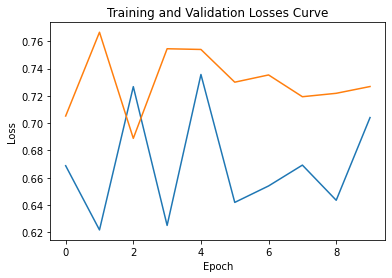

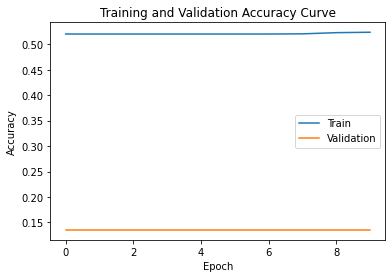

In [ ]:
model2 = RNN(100, input_size)
train_network(model2, train, valid, batch_size=64, num_epochs=10, learning_rate=0.00001)
# because of how noisy the previous graph was, I decided to decrease the learning rate back to the default value

In [ ]:
class RNN_new(nn.Module):
  def __init__(self, hidden_size, input_size):
    super(RNN_new, self).__init__()
    self.name = "RNN_new"
    self.emb = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, 2)

  def forward(self, x):
    x = self.emb[x]
    h = torch.zeros(1, x.size(0), self.hidden_size)
    out, _ = self.rnn(x, h)
    out = self.fc(torch.max(out, dim=1)[0])
    return out

Epoch 1: 	Training Accuracy: 0.5199801028021886 Training Loss: 0.6731995344161987 
Validation Accuracy: 0.13452914798206278 Validation Loss: 0.7029852867126465
Epoch 2: 	Training Accuracy: 0.5199801028021886 Training Loss: 0.6264525055885315 
Validation Accuracy: 0.13452914798206278 Validation Loss: 0.7620802521705627
Epoch 3: 	Training Accuracy: 0.5199801028021886 Training Loss: 0.7316845059394836 
Validation Accuracy: 0.13452914798206278 Validation Loss: 0.6873581409454346
Epoch 4: 	Training Accuracy: 0.5199801028021886 Training Loss: 0.6320213079452515 
Validation Accuracy: 0.13452914798206278 Validation Loss: 0.7587194442749023
Epoch 5: 	Training Accuracy: 0.5199801028021886 Training Loss: 0.7408202886581421 
Validation Accuracy: 0.13452914798206278 Validation Loss: 0.7616016268730164


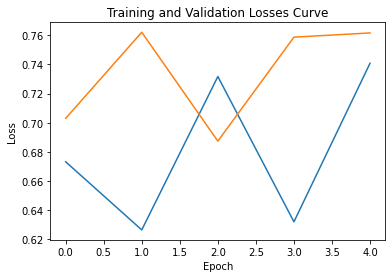

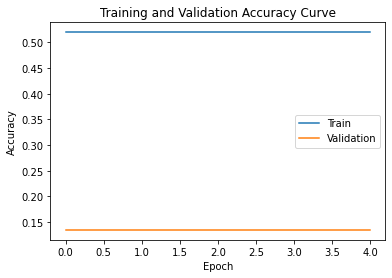

In [ ]:
# In my third test, I used a new model with a maxpooling layer and used the same parameters from the initial test, since
# those produced the best results thus far.
model3 = RNN_new(input_size, input_size)
train_network(model3, train, valid, batch_size=64)

In [ ]:
# For the fourth test, I decided to re-use the new model but increase both the number of epochs and
# learning rate to see how the accuracy would be improved.

Epoch 1: 	Training Accuracy: 0.6028850936826397 Training Loss: 0.6890957355499268 
Validation Accuracy: 0.8816143497757848 Validation Loss: 0.6834397912025452
Epoch 2: 	Training Accuracy: 0.7927375227988724 Training Loss: 0.6344205141067505 
Validation Accuracy: 0.6313901345291479 Validation Loss: 0.6885555982589722
Epoch 3: 	Training Accuracy: 0.5571215387166307 Training Loss: 0.6832975149154663 
Validation Accuracy: 0.20538116591928252 Validation Loss: 0.6304253935813904
Epoch 4: 	Training Accuracy: 0.9399767866025535 Training Loss: 0.40191373229026794 
Validation Accuracy: 0.8834080717488789 Validation Loss: 0.635581374168396
Epoch 5: 	Training Accuracy: 0.9283700878792903 Training Loss: 0.46885061264038086 
Validation Accuracy: 0.915695067264574 Validation Loss: 0.496046245098114
Epoch 6: 	Training Accuracy: 0.9376554468579008 Training Loss: 0.3499974310398102 
Validation Accuracy: 0.9524663677130045 Validation Loss: 0.4398140609264374
Epoch 7: 	Training Accuracy: 0.939147736693749

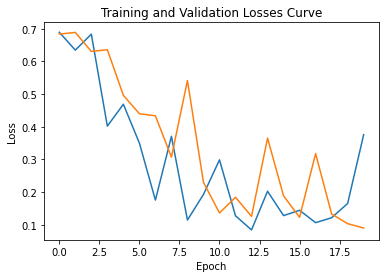

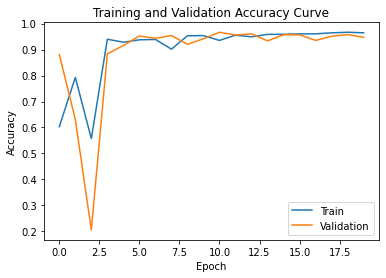

In [ ]:
model4 = RNN_new(input_size, input_size)
train_network(model4, train, valid, batch_size=64, num_epochs=20, learning_rate=0.0001)

Epoch 1: 	Training Accuracy: 0.5201459127839496 Training Loss: 0.6633753180503845 
Validation Accuracy: 0.13452914798206278 Validation Loss: 0.719833254814148
Epoch 2: 	Training Accuracy: 0.5199801028021886 Training Loss: 0.7260542511940002 
Validation Accuracy: 0.13452914798206278 Validation Loss: 0.6968817114830017
Epoch 3: 	Training Accuracy: 0.5468413198474548 Training Loss: 0.6662924885749817 
Validation Accuracy: 0.18206278026905828 Validation Loss: 0.7072526812553406
Epoch 4: 	Training Accuracy: 0.5398773006134969 Training Loss: 0.6271592378616333 
Validation Accuracy: 0.17219730941704037 Validation Loss: 0.7105566263198853
Epoch 5: 	Training Accuracy: 0.5698889073122202 Training Loss: 0.7037004828453064 
Validation Accuracy: 0.23139013452914797 Validation Loss: 0.7072412967681885
Epoch 6: 	Training Accuracy: 0.6367103299618637 Training Loss: 0.6817551255226135 
Validation Accuracy: 0.357847533632287 Validation Loss: 0.6956121325492859
Epoch 7: 	Training Accuracy: 0.889570552147

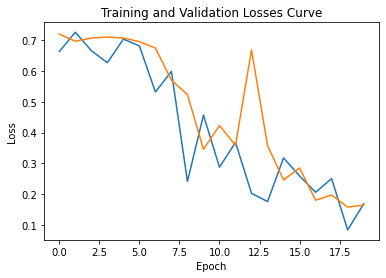

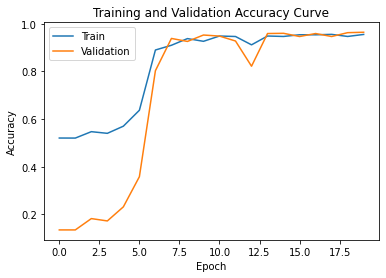

In [ ]:
# The final accuracy from the previous test was really good, but I tried lowering the learning rate to help with the
# noisiness of the graph.
model5 = RNN_new(input_size, input_size)
train_network(model5, train, valid, batch_size=64, num_epochs=20, learning_rate=0.00005)

In [ ]:
# In the end, the best validation accuracy that I achieved was 0.9641255605381166 and the best training accuracy was 0.9383186867849445.

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset([e for e in valid.examples if e.label == 0], valid.fields)

valid_false_positive = 1 - get_accuracy(model5, valid_spam, batch_size=64)
valid_false_negative = 1 - get_accuracy(model5, valid_nospam, batch_size=64)

print("The False Positive rate is: {} %".format(valid_false_positive*100))
print("The False Negative rate is: {} %".format(valid_false_negative*100))

The False Positive rate is: 4.666666666666663 %
The False Negative rate is: 3.5233160621761628 %


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [ ]:
# A false positive could cause actual sms messages to be classified as spam and be blocked or sent to a spam folder,
# resulting in the user losing out on important information. This could prove to be very dangerous in the case of a
# message regarding someone's health or even a job offer.

# On the other hand, a false negative could allow spam messages to pass through to a user's inbox, resulting in the
# user receiving unwanted and harmful messages.

# Therefore, a false positive could cause a user to miss out on impportant information while a false negative could cause a user to
# receive unwanted/harmful messages.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
test_accuracy = get_accuracy(model5, test, batch_size=64)

print("The final test accuracy is {} %.".format(test_accuracy*100))

The final test accuracy is 96.67863554757629 %.


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.legacy.data.Dataset([e for e in test.examples if e.label == 0], valid.fields)

test_false_positive = 1 - get_accuracy(model5, test_spam, batch_size=64)
test_false_negative = 1 - get_accuracy(model5, test_nospam, batch_size=64)

print("The False Positive rate is: {} %".format(test_false_positive*100))
print("The False Negative rate is: {} %".format(test_false_negative*100))

The False Positive rate is: 6.711409395973156 %
The False Negative rate is: 2.797927461139893 %


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"
sms_indexes = []

for n in msg:
  index = text_field.vocab.stoi[n]
  sms_indexes.append(index)

sms_tens = torch.tensor(sms_indexes)
sms_tens = sms_tens.unsqueeze(0)

final_prediction = model5(sms_tens)
final_prediction = F.softmax(final_prediction, dim=1)

print(final_prediction)

tensor([[0.8436, 0.1564]], grad_fn=<SoftmaxBackward>)


In [ ]:
# Therefore, my model predicted a 15.64% chance that the message is a spam which is not optimal.
# The message we were given is obviously not a spam message, so this outcome is a bit misleading.

### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
# I personally believe that at a level such as this, where the task of detecting spams is made into a simple binary classification problem,
# the task is relatively easy and high accuracy scores can be achieved through the use of reccurent neural networks. However, once different
# techniques such as message customization are used to evade detection and the sheer volume of spam messages are taken into account, I believe
# that the task of detecting spam messages becomes much more difficult.

# Since this is a binary classification problem, a simple baseline model would be to use a decision tree. We could achieve such a model by
# collecting data and extracting features from it to divide them into two different classes: spam or not spam. This would prove to be a relatively
# inexpensive model which could be used to benchmark the RNN.